#Linear Algebra for Data Science: HW3, task 1 (2.5 pts)
#Background extraction via SVD
#<div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   Roman Kovalchuk
*   Eduard Pekach

The aim of this task is to use the SVD-based $k$-rank approximation of a given matrix to extract the background of a video sequence of frames

In [7]:
import numpy as np
import cv2
#import os
#import gdown
from PIL import Image
from IPython.display import HTML
from base64 import b64encode

# gdown.download("https://drive.google.com/file/d/1HpNTozAlQN5EREPs1IL2JmrrNEfrWckA/view?usp=sharing", "video.mp4", quiet=False)

def show_video(video_path, video_width = 600):

  mp4 = open(video_path,'rb').read()
  print(len(mp4))
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

#1. Preparation (0.5 pts)

-  take a short video with a fixed background and relatively small moving part
- extract $N$ equally spaced frames and convert them to greyscale images
- reshape each image into a column vector of size $M\times 1$, with $M:=w\times h$
- form a matrix $A$ of $N$ columns

In [8]:
video_file = "video.mp4"

# Load the video using OpenCV
cap = cv2.VideoCapture(video_file)

# Get the number of frames and height, width of each frame
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

N = 50 # select desired number of frames
frame_indices = np.linspace(0, num_frames - 1, N, dtype=int) # create equaly distributed frame indices over whole video

# Initialize an array to store the selected frames
frames = np.zeros((N, frame_height, frame_width), dtype=np.float32)

# Loop through the selected frames and store them
for i, index in enumerate(frame_indices):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, frame = cap.read()
    frames[i] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0 # convert to GrayScale using cv2 and normalize uint8 to floats [0.0, 1.0]

# Release the video capture
cap.release()

# Reshape each frame into a column vector
M = frame_height * frame_width
A = frames.reshape(N, M).T



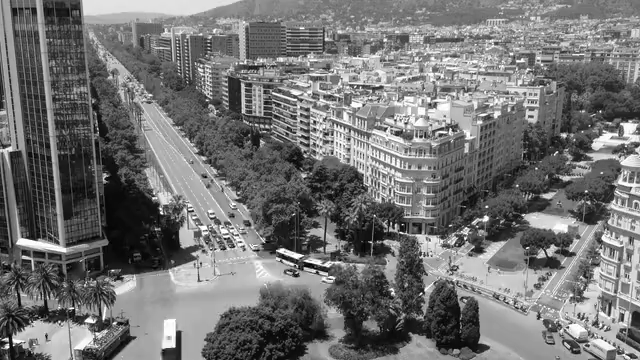

In [9]:
# Visualize any frame from matrix A to make shure that everything is OK with your data
Image.fromarray((A[:, 0].reshape(frame_height, frame_width)*255).astype(np.uint8))


# 2. Background extraction (1 pt)

We have the matrix $A$ of $N$ (no. of frames) columns and $M = w \times h$ rows. Our aim here is to find the best rank-$1$ approximation $\mathbf{u}\mathbf{v}^\top$ of $A$

- recall that $\mathbf{v}$ is the eigenvector of an $N\times N$ matrix $A^\top A$ corresponding to the largest eigenvalue; power method should find them very fast
- how do we find $\mathbf{u}$ given $\mathbf{v}$?
---
Low rank approximation of an m × n matrix A is a problem, where the goal is to replace the matrix $A$ with a rank-k matrix $A_0$ which well-approximates $A$, in the sense that
$kA − A_0 k$ is small under some measure $k · k$. Since any rank-k matrix $A_0$
can be written as $U · V$ , where $U$ is $m × k$ and $V$ is $k × n$, this allows for a significant parameter reduction. Namely, instead of storing $A$, which has $mn$ entries, one can
store $U$ and $V$ , which have only $(m+n)k$ entries in total. Moreover, when computing $Ax$, one can first compute $V x$ and then $U(V x)$, which takes $(m + n)k$
instead of $mn$ time.

Speaking about finding $u$ given $v$, we can use similar formula we derived from classical/reduced SVD:
$$
A * \vec{v}_n = \sigma_n * \vec{u}_n => \vec{u}_n = \frac{1}{\sigma_n} * A * \vec{v}_n
$$
And for reduced SVD:
$$
A * \vec{v}_1 = \sigma_1 * \vec{u}_1 => \vec{u}_1 = \frac{1}{\sigma_1} * A * \vec{v}_1
$$

---
- use $\mathbf{u}\mathbf{v}^\top$ as a background
- remove background from the frames and recombine them into a video with moving part only


In [10]:
A_tA = np.dot(A.T, A)

# Define the number of iterations
num_iterations = 100

# Initialize a random vector v
v = np.random.rand(A.shape[1]).astype(np.float32)

# Normalize the vector v
v = v / np.linalg.norm(v)

# Loop through the iterations
for i in range(num_iterations):
    # Calculate Av
    Av = np.dot(A_tA, v)

    # Normalize Av
    Av = Av / np.linalg.norm(Av)

    # Replace v with Av
    v = Av

# Calculate the largest eigenvalue
lambda_max = np.dot(np.dot(v, A_tA), v)

# Calculate the rank-1 approximation of A

uvt = np.outer(np.dot(A, v), v)

# Remove the background from the frames
background = uvt.reshape((A.shape[0], A.shape[1]))
A_foregrounds = np.abs(A - background)
foregrounds = A_foregrounds.reshape((frame_height, frame_width, N)).transpose((2,0,1)) * 255
foregrounds = foregrounds.astype(np.uint8)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 20, (frame_width*2, frame_height))
for i in range(N):
    frame = np.concatenate(((frames[i] * 255).astype(np.uint8), foregrounds[i]), axis=1)
    out.write( cv2.cvtColor( frame  , cv2.COLOR_GRAY2BGR) )
out.release()

In [ ]:
show_video("output.mp4")

In case colab doesn't show the video, download it to local storage

In [ ]:
from google.colab import files
files.download("output.mp4")

# 3. Rank-$k$ approximation (0.5 pts)

Here, we'll discuss the question whether taking approximation of $A$ of larger rank improves background extraction


- find the best approximation $A_k$ of the matrix $A$ of rank $k$ (can use the built-in SVD function)
- use the columns of $A_k$ as frames of the background
- remove the background from the original frames
- form two videos, with background and moving part
- comment on the results for $k=2, 5, 10$

In [17]:
rank = 10 # choose desired rank
U,s, Vh = np.linalg.svd(A, full_matrices=False) # Hint: look up svd docs, to make it work more memory efficiently
A_approx = np.dot(U[:, :rank] * s[:rank], Vh[:rank, :])

In [18]:
background = A_approx.reshape(A.shape[0], A.shape[1])
frames_without_background = np.abs(A - background)
foregrounds = frames_without_background.reshape((frame_height, frame_width, N)).transpose((2,0,1)) * 255
foregrounds = foregrounds.astype(np.uint8)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(f'output2_{rank}.mp4', fourcc, 20, (frame_width*2, frame_height))
for i in range(N):
    frame = np.concatenate(((frames[i] * 255).astype(np.uint8), foregrounds[i]), axis=1)
    out.write( cv2.cvtColor( frame  , cv2.COLOR_GRAY2BGR) )
out.release()

# 3 Comments:

As we can see with different ranks : 2, 5, 10 ; The output matrix captures more and more details from the original. However, the difference is not a marginal, we can get a notion, that with increase of this parameter,
we get more details, as the reflections from the cars begin to appear.
Though, the difference is very slight, and we can state, that larger approximations $A$ with larger values of $k$ in this case does not improve background extraction

# 4. Conclusions (0.5 pts)

- Explain why the rank-$1$ approximation of the matrix $A$ typically extracts the background from video
- Discuss whether rank-$k$ approximation improves the process
- Think of advantages, disadvantages, and limitations of the methods
- You can also add some suggestions how this task can be improved in the future

---
1) Why rank-1 approximation of the matrix $A$ extracts the background from video:

We have constructing rank ‘1’ matrix with the highest singular value.
For this we took the first column of $U$ multiply it with first row of $V^T$ and then multiplying it with the first diagonal value of $Σ$. It gives us rank one approximation of original matrix.

After that we took one row from the approximated matrix and reshape it to the shape of the frame taken from the video.
This approximated frame shows the background in video, because it contains the common part in all frame which is the background.

Low rank matrix is actually approximation of original matrix. As we increases the rank of the matrix we get closer to the original matrix.

In natural images, we know there are a lot of dependencies, no sudden change occur in images. Most of the columns are dependent of each other. So, taking it as an advantage, we can approximate natural images with low-rank matrix and in some cases we get high accuracy.

2) Discuss whether the rank-$k$ approximation improves the process

Low rank matrices appear throughout different applications and field. An exceptionally useful example, would be the algorithm's usage in Big Data. As with bigger matrices, the computational needs grows, efficient approximation becomes more and more crucial. Specifically, In Machine Learning, low rank approximations to data tables are often employed to impute missing data, denoise noisy data, or perform feature extraction.
Furthermore, the algorithm has a lot of modifications, very popular and is easy to extend, as for example Johnson-Lindenstrauss variant for Extremely large matrices, where instead of U and V matrices, authors approximate it with
$X = \~U\~V^T$, where $\~U = U\surd\Sigma$ and$\~V = V\surd\Sigma$.

3) Advantages and Disadvantages:

###### Advantages
- _Simplicity and versatility, various modifications exists_:

Rank-1 approximations are often simpler to compute and understand compared to higher-rank approximations. The resulting matrix is of a much simpler form, making it easier to analyze and work with.

- _Simple mathematical background_:

Rank-1 approximations are closely related to the concept of eigenvalue decomposition. It's easy to understand and explain to non-technical people.

###### Disadvantages:
- _Loss of Information_:

Rank-1 approximations discard information from the original matrix. While this can be advantageous for dimensionality reduction, it also means that the approximation may not accurately represent the entire matrix.

- _Not Always Optimal_:

The rank-1 approximation might not always be the best choice for certain applications. Depending on the specific requirements of a problem, higher-rank approximations or different matrix factorizations may be more appropriate.

- _Computationally Intensive for Large Matrices_:

While rank-1 approximations are computationally simpler than higher-rank approximations, they can still be computationally intensive for very large matrices. However the modifications for solving this problem exist: (Johnson-Lindenstrauss modification)

4) You can also add some suggestions how this task can be improved in the future:

As was mentioned in previous tasks, in order to use this method for very large matrices, its modifications can be applied. For instance, when we deal with huge dimension scales, Johnson-Lindenstrauss modification can be applied.
When we deal with Complex real, we should modify the algorithm and use Hermitian.
Although, in a general use case, classical algorithm would do the job, if to say we only need to extract a background from CCTV camera, motion of cars from static video for some further Deep Learning model training, etc.

---